# Household Energy Demand Predictions for IoT Systems

## Datasource:

**Individual household electric power consumption Data Set**
https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption

In [72]:
import pandas as pd

data_base = pd.read_csv("./data/household_power_consumption.txt",
                        header=0,
                        squeeze=True,
                        delimiter=";",
                        na_values=["?"],
                        dtype={
                            "Time": str,
                            "Date": str,
                            "Global_active_power": float,
                            "Global_reactive_power": float,
                            "Voltage": float,
                            "Global_intensity": float,
                            "Sub_metering_1": float,
                            "Sub_metering_2": float,
                            "Sub_metering_3": float
                        })

data_base["timestamp"] = pd.to_datetime(data_base["Date"] + " " + data_base["Time"], format="%d/%m/%Y %H:%M:%S")
data_base["date_filter"] = pd.to_datetime(data_base["Date"] + " " + data_base["Time"], format="%d/%m/%Y %H:%M:%S")
data_base = data_base.set_index("timestamp")

data_base[["Date", "Time", "Global_active_power"]].head(5)

,Date,Time,Global_active_power
timestamp,,,
2006-12-16 17:24:00,16/12/2006,17:24:00,4.216
2006-12-16 17:25:00,16/12/2006,17:25:00,5.360
2006-12-16 17:26:00,16/12/2006,17:26:00,5.374
2006-12-16 17:27:00,16/12/2006,17:27:00,5.388
2006-12-16 17:28:00,16/12/2006,17:28:00,3.666


## Filtering the Dataset

* *Start Date:* lower time boundary (inclusive).
* *End Date:* upper time boundary (exclusive).
* *Feature:* selected field for the univariate time series analysis.

In [73]:
start_date = "2007-07-01"
end_date = "2007-07-08"
feature = "Global_active_power"

def clean_data(dataframe):
    date_range = (data_base["date_filter"] >= start_date) & (data_base["date_filter"] < end_date)
    return dataframe.dropna(subset=[feature]).loc[date_range][feature].resample("1H").mean()

def seasonal_fill(s, days):
    return s.fillna(s.shift(-24 * days))

series = seasonal_fill(clean_data(data_base), 1)

# Check for missing values
series[series.isnull()]

Series([], Freq: H, Name: Global_active_power, dtype: float64)

## Dataset Exploration

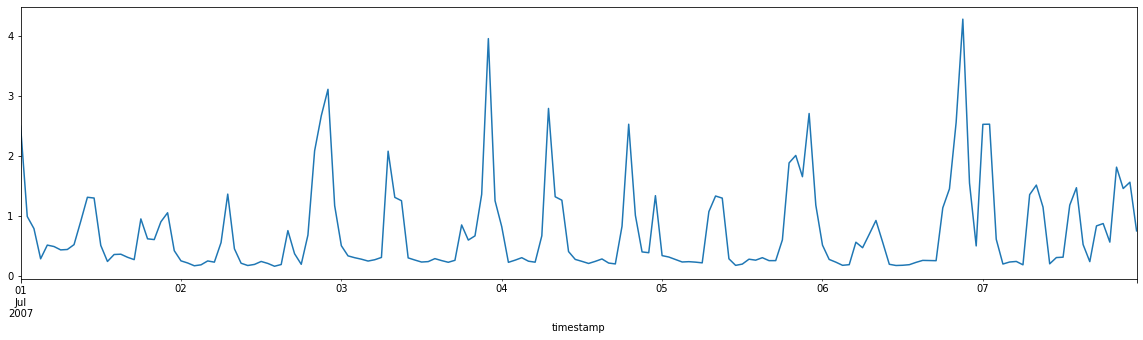

In [74]:
import matplotlib as plt
plt.rcParams["figure.figsize"] = (20,5)

series.plot()
plt.pyplot.show()

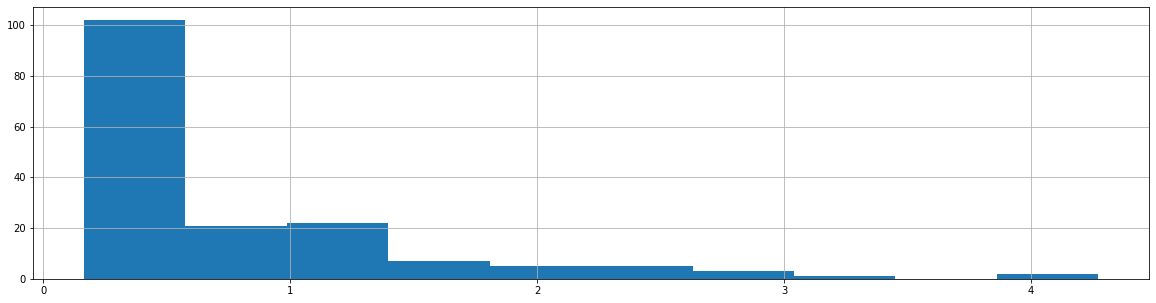

In [75]:
series.hist()
plt.pyplot.show()

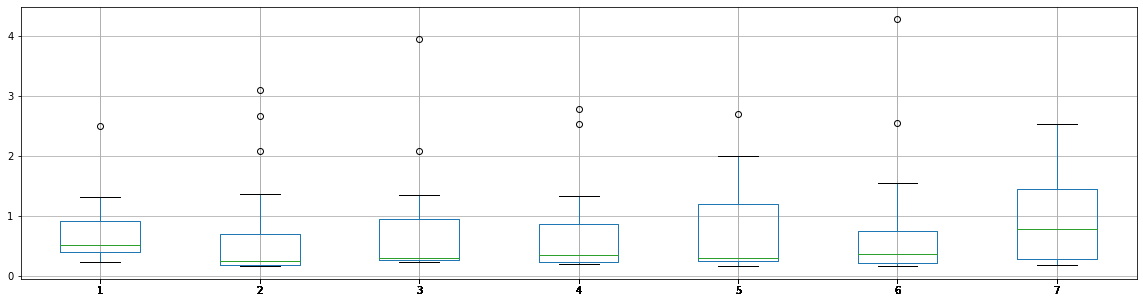

In [76]:
pd.DataFrame(series).set_index(series.index.day, append=True).unstack().boxplot()
plt.pyplot.xticks(series.index.day, list(series.index.day))
plt.pyplot.show()

**Lag Plot (t + 1):** check the correlation of time shifted measurements (each increment is the median value of a 1 hour sample).

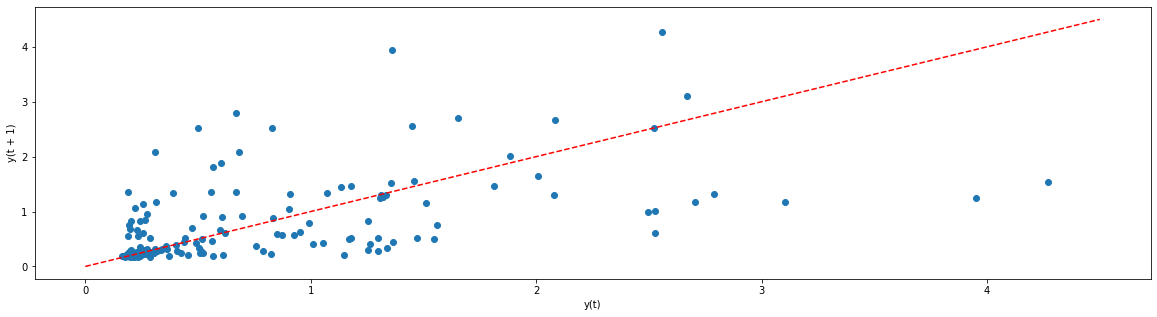

In [77]:
pd.plotting.lag_plot(series)
ident = [0.0, 4.5]
plt.pyplot.plot(ident,ident, color="red", linestyle="--")
plt.pyplot.show()

**Autocorrelation Plot:** discover the behaviour of autocorrelation scores according to time lags.

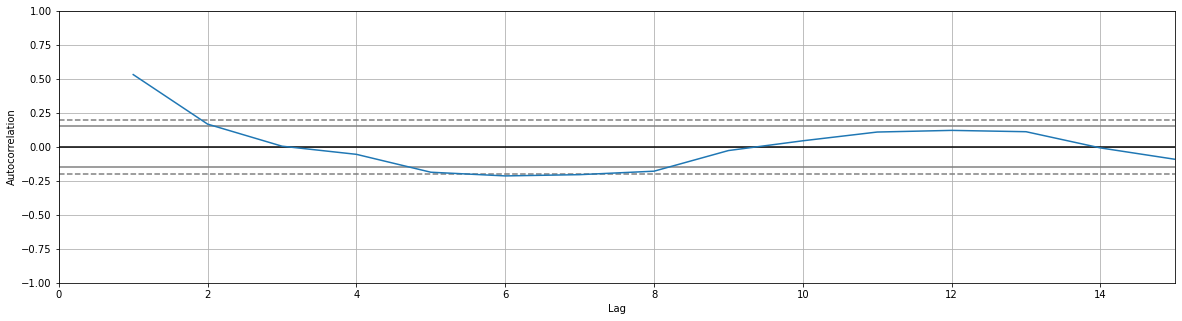

In [78]:
pd.plotting.autocorrelation_plot(series)
plt.pyplot.xlim([0,15])
plt.pyplot.show()

**Seasonal Decomposition:** check global trends and seasonal patterns.

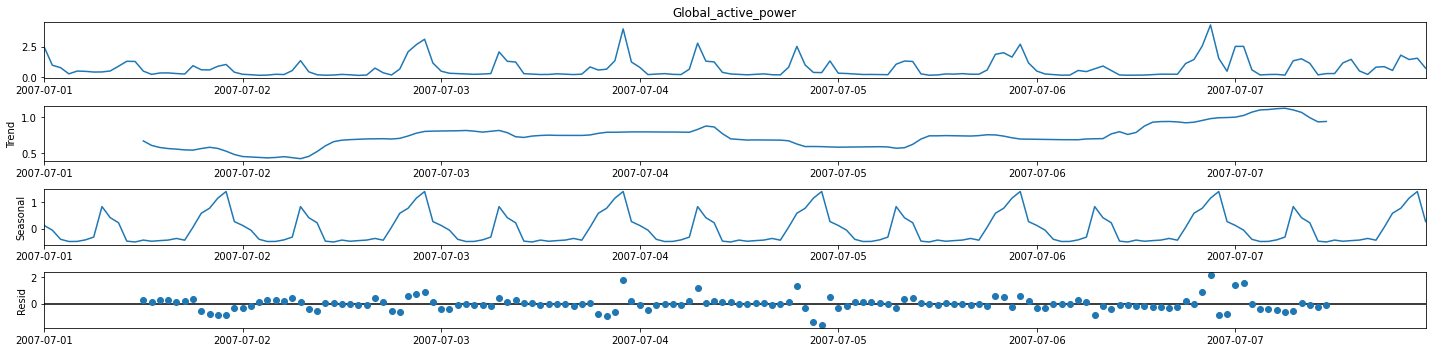

In [79]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_decompose(series, model='additive').plot()
plt.pyplot.show()

**Augmented Dickey Fuller Test (ADF Test):** hypothesis test for dataset stationarity (lower the *p-value* the better).

In [80]:
from statsmodels.tsa.stattools import adfuller

X = series.values
result = adfuller(X)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]:0.10f}")
print('Critical Values:')
for key, value in result[4].items():
    print(f"\t{key}: {value}")

ADF Statistic: -6.438599176656573
p-value: 0.0000000163
Critical Values:
	1%: -3.471118535474365
	5%: -2.8794405060097024
	10%: -2.576313761526591


## Baseline Model

Find the error rate of the most obvious algorithm [Y(t+1) = Y(t)]

In [81]:
values = pd.DataFrame(series.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']
dataframe.head(5)

,t,t+1
0,NaN,2.493733
1,2.493733,0.990900
2,0.990900,0.789900
3,0.789900,0.287467
4,0.287467,0.515533


In [82]:
from sklearn.metrics import mean_squared_error
from math import sqrt

X = dataframe.values
train_size = int(len(X) * 0.7)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

def model_baseline(x):
  return x

def RMSE(expected, predicted):
    return sqrt(mean_squared_error(expected, predicted))

def validate_model(model, cost, expected, validation):
    p = [model(x) for x in validation]
    return cost(expected, p), p

In [83]:
%%time
error, predictions = validate_model(model=model_baseline,
                                    cost=RMSE,
                                    expected=test_y,
                                    validation=test_X)

print(f"Baseline RMSE: {error}")

Baseline RMSE: 0.805271735851999
CPU times: user 570 µs, sys: 81 µs, total: 651 µs
Wall time: 621 µs


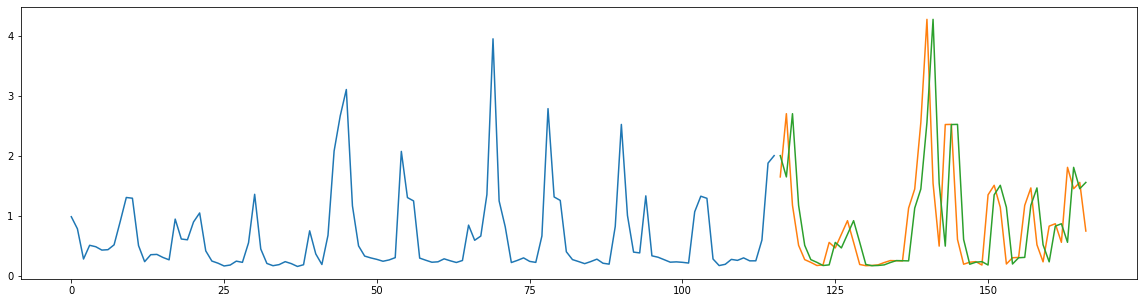

In [84]:
plt.pyplot.plot(train_y)
plt.pyplot.plot([None for i in train_y] + [x for x in test_y])
plt.pyplot.plot([None for i in train_y] + [x for x in predictions])
plt.pyplot.show()

## ARIMA

State of the art Autoregressive model

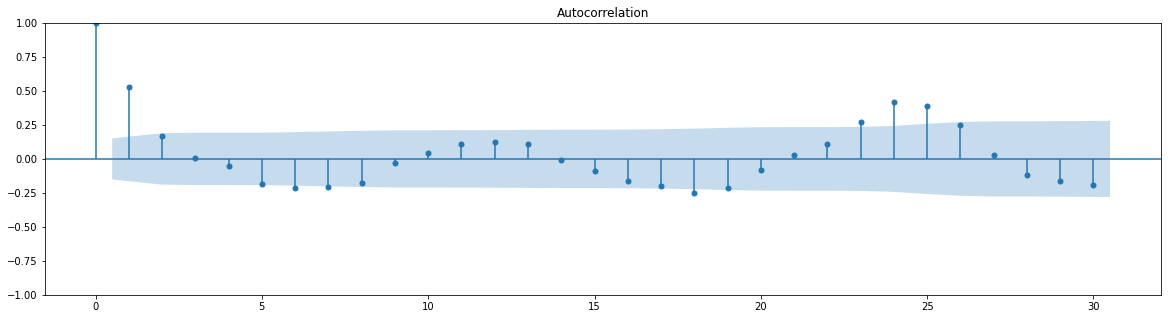

In [85]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf = plot_acf(series, lags=30)

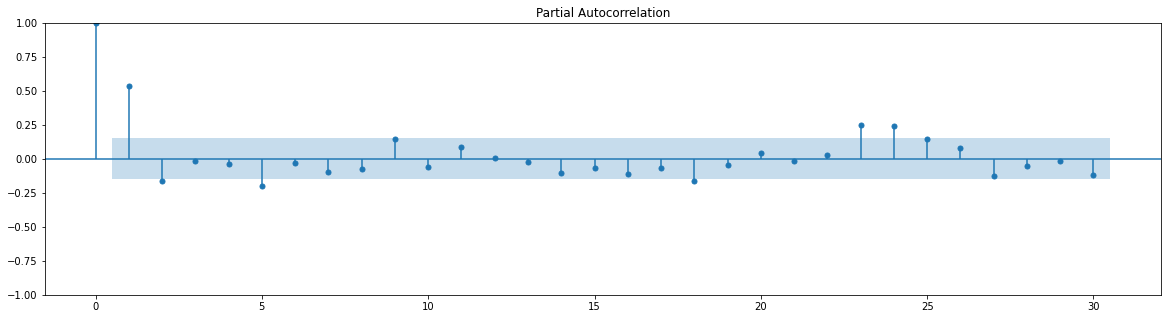

In [86]:
pacf = plot_pacf(series, lags=30)

In [87]:
import warnings
from math import sqrt
import itertools
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.7)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	model = ARIMA(history, order=arima_order)
	model_fit = model.fit()
	predictions = model_fit.forecast()
	rmse = RMSE([test[0]], predictions)
	return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for order in itertools.product(p_values, d_values, q_values):
        rmse = evaluate_arima_model(dataset, order)
        if rmse < best_score:
            best_score, best_cfg = rmse, order
    print(f"Best ARIMA{best_cfg} RMSE={best_score}")
    return best_cfg

# evaluate parameters
p_values = [0,1,2]
d_values = [0,1,2]
q_values = [0,1,2]

In [88]:
%%time
warnings.filterwarnings("ignore")
best_cfg = evaluate_models(series.values, p_values, d_values, q_values)

Best ARIMA(2, 0, 1) RMSE=0.17948428952692508
CPU times: user 5 s, sys: 742 ms, total: 5.74 s
Wall time: 2.08 s


In [89]:
%%time
history = [x for x in train_X]

def arima_model(x):
    best_fit = ARIMA(history, order=best_cfg).fit()
    history.append(x)
    return best_fit.forecast()[0]

error, predictions = validate_model(model=arima_model,
                                    cost=RMSE,
                                    expected=test_y,
                                    validation=test_X)

print(f"ARIMA RMSE: {error}")

ARIMA RMSE: 0.9073866674227618
CPU times: user 11 s, sys: 1.19 s, total: 12.2 s
Wall time: 6.12 s


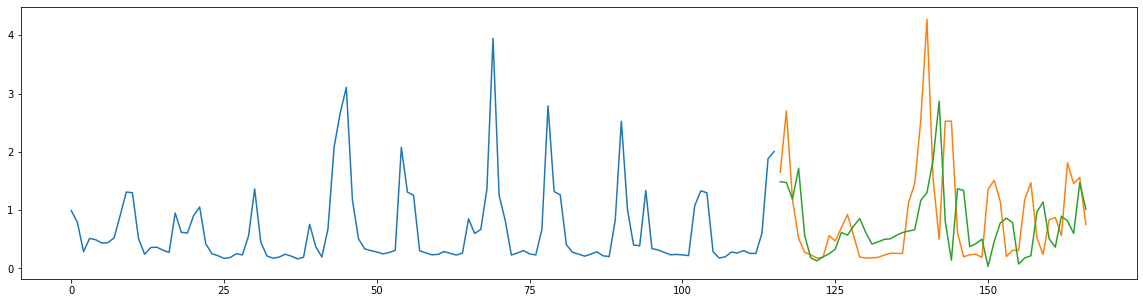

In [90]:
plt.pyplot.plot(train_y)
plt.pyplot.plot([None for i in train_y] + [x for x in test_y])
plt.pyplot.plot([None for i in train_y] + [x for x in predictions])
plt.pyplot.show()